# Import libraries

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import os
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Read data from CSV files

In [2]:
df_train = pd.read_csv('./data/adult.data')
df_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
df_test = pd.read_csv('./data/adult.test')
df_test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


# Preprocess data

## Extract list of labels categories to .txt files

In [4]:
label_encoders = {}
for column in df_train.select_dtypes(include=['object']).columns:
    labels = df_train[column].unique()
    with open(f'./categories/{column}.txt', 'w') as file:
        for label in labels:
            file.write(f'{label}\n')

## Encode data

In [5]:
mapping_folder_path = './categories'
file_extension = '.txt'
file_list = [file_name for file_name in os.listdir(mapping_folder_path) if file_name.endswith(file_extension)]

for file_name in file_list:
    column = file_name.split('.')[0]
    with open(f'./categories/{file_name}', 'r') as file:
        labels = []
        for line in file:
            labels.append(line.strip())
        label_encoder = LabelEncoder()
        label_encoder.fit(labels)
        df_train[column] = label_encoder.transform(df_train[column])
        df_test[column] = label_encoder.transform(df_test[column])

df_train = df_train.dropna()
df_test = df_test.dropna()
X_train = df_train.drop('income', axis=1).drop('fnlwgt', axis=1)
y_train = df_train['income']
X_test = df_test.drop('income', axis=1).drop('fnlwgt', axis=1)
y_test = df_test['income']

## Standardize data

In [6]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_train_std = X_train_std.astype('float32')
X_test_std = scaler.transform(X_test)
X_test_std = X_test_std.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Deep Neural Network (DNN)

## Create model

In [7]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_std.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2023-12-21 12:38:40.827320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-21 12:38:40.827419: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-21 12:38:40.827450: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-12-21 12:38:40.827469: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-12-21 12:38:40.827490: W tensorf

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1792      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 12,673
Trainable params: 12,673
Non-trainable params: 0
_________________________________________________________________


## Train model

In [9]:
history = model.fit(X_train_std, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
814/814 [==============================] - 1s 1ms/step - loss: 0.3581 - accuracy: 0.8327 - val_loss: 0.3307 - val_accuracy: 0.8460
Epoch 2/10
814/814 [==============================] - 1s 966us/step - loss: 0.3257 - accuracy: 0.8469 - val_loss: 0.3220 - val_accuracy: 0.8477
Epoch 3/10
814/814 [==============================] - 1s 929us/step - loss: 0.3217 - accuracy: 0.8483 - val_loss: 0.3220 - val_accuracy: 0.8469
Epoch 4/10
814/814 [==============================] - 1s 1ms/step - loss: 0.3183 - accuracy: 0.8529 - val_loss: 0.3171 - val_accuracy: 0.8485
Epoch 5/10
814/814 [==============================] - 1s 960us/step - loss: 0.3150 - accuracy: 0.8522 - val_loss: 0.3183 - val_accuracy: 0.8511
Epoch 6/10
814/814 [==============================] - 1s 923us/step - loss: 0.3125 - accuracy: 0.8545 - val_loss: 0.3185 - val_accuracy: 0.8532
Epoch 7/10
814/814 [==============================] - 1s 938us/step - loss: 0.3093 - accuracy: 0.8535 - val_loss: 0.3141 - val_accuracy: 0.8

## Test model

In [10]:
y_pred_proba = model.predict(X_test_std)
y_pred = (y_pred_proba > 0.5).astype(int)

509/509 [==============================] - 0s 477us/step


## Evaluate

In [11]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.85


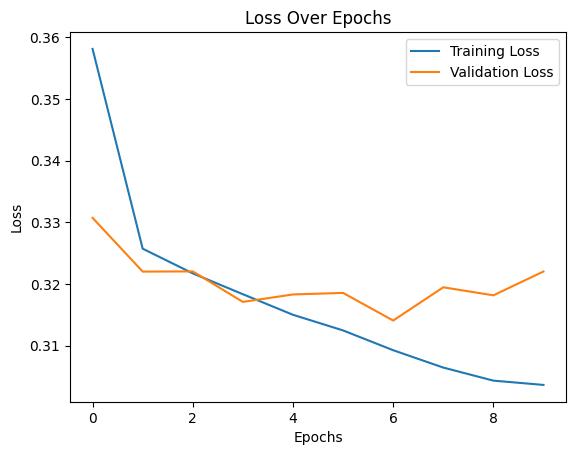

In [12]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

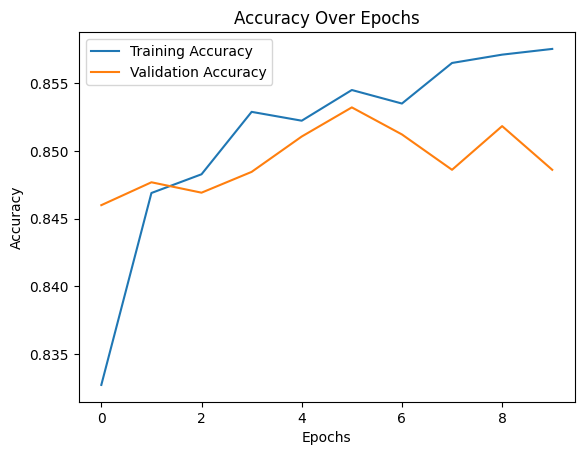

In [13]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Save model and weights

In [14]:
model.save_weights('./weights/dnn.h5')
model.save('./models/dnn')

INFO:tensorflow:Assets written to: ./models/dnn/assets


INFO:tensorflow:Assets written to: ./models/dnn/assets


# SVM

## Train model

In [15]:
svm_model = SVC(kernel='linear', verbose=True)
svm_model.fit(X_train_std, y_train)

[LibSVM]..........................................................................................................
*......*................................................................................*...........................................*..........*
optimization finished, #iter = 245020
obj = -13084.336019, rho = -0.947115
nSV = 13097, nBSV = 13069
Total nSV = 13097


SVC(kernel='linear', verbose=True)

## Test model

In [16]:
y_pred = svm_model.predict(X_test_std)

## Save model

In [20]:
with open('svm_model.pkl', 'wb') as model_file:
    pickle.dump(svm_model, model_file)

## Evaluate

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.81


# Logistic Regression

## Train model

In [ ]:
classifier = LogisticRegression()
classifier.fit(X_train_std, y_train)

LogisticRegression()

## Test model

In [ ]:
predictions = classifier.predict(X_test)

c:\Works\predict-adult-income\venv\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


## Evaluate model

In [ ]:
accuracy = accuracy_score(y_test, predictions)
print(accuracy)

0.23622627602727106
